# Task 2: Sentiment Analysis on Amazon Product Reviews

Task Overview
Objective: Create a sentiment analysis classifier to label reviews as positive, neutral, or negative.

Deliverables:

Preprocessing pipeline (tokenization, stopword removal)\
Labeled dataset and train/test sets\
Model training (Naive Bayes, LSTM, or BERT)\
Visualization of word clouds and confusion matrix

In [37]:
from faker import Faker
import random
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [38]:
fake = Faker()

reviews = [fake.text(max_nb_chars=200) for _ in range(5000)]
labels = [random.choice(['positive', 'neutral', 'negative']) for _ in range(5000)]

In [39]:
reviews[:5], labels[:5]  # Display first 5 reviews and their labels for verification

(['Certain improve candidate choice. Find bill beyond me trial blood large public. Doctor high create husband stand car better knowledge.',
  'Entire table join Mrs interview office. Seem unit smile fund. Effort federal people us both other. Here and mouth give sort material sea.\nFood report at create. Leader protect TV couple.',
  'Laugh move gas despite keep. Worry significant nation later reveal.',
  'Appear account course alone difficult difference benefit. Meet because hit stand do result. Movie many financial hope study about.',
  'Which give dinner decide rate stuff. Rich detail dark car still response concern.\nMan lawyer road news remember talk positive western. Machine entire buy mind.'],
 ['positive', 'neutral', 'negative', 'positive', 'negative'])

### Preprocess data

In [40]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_tab = tf.strings.regex_replace(lowercase, '\n', ' ')
  return tf.strings.regex_replace(stripped_tab,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [41]:
custom_standardization("Hello, World!\nThis is a test.")  # Test the custom standardization function

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world this is a test'>

In [42]:
# Encode labels into integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
label_map_rev = {0: 'negative', 1: 'neutral', 2: 'positive'}

encoded_labels = [label_map[l] for l in labels]
encoded_labels[:10]

[2, 1, 0, 2, 0, 2, 0, 2, 0, 0]

In [43]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)

In [44]:
X_train[:5], y_train[:5]  # Display first 5 training samples and their labels for verification

(['Network floor play amount. Would anything activity green simple he.\nIdentify ago kitchen plan exist. Fight today group field. Force example center present knowledge thus forget here.',
  'Season well she again toward stock. Central college now community may. More class church short seem civil expect. Game my could add.',
  'Carry soldier security herself agreement. Animal term customer especially down. Improve form value Mrs remember.',
  'Second chance though condition add again. Recognize lay plan traditional.\nOperation we benefit good respond interest prevent. Agency fly our painting game attention.',
  'Upon top factor. Attack value those center fill.\nProperty key talk growth lead owner campaign much. Attack risk suggest movement not.'],
 [2, 2, 0, 2, 2])

In [45]:
max_features = 1000 # vocabulary size - The number of unique words your TextVectorization layer will keep (the vocabulary size).
sequence_length = 100 # How many tokens (words) are kept per review (extra words truncated, shorter ones padded).

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [46]:
vectorize_layer.adapt(X_train)

In [47]:
def vectorize_text(text, label):
  # text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [48]:
# retrieve a batch (of 32 reviews and labels) from the dataset
first_review, first_label = reviews[0], labels[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review Certain improve candidate choice. Find bill beyond me trial blood large public. Doctor high create husband stand car better knowledge.
Label positive
Vectorized review (<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([436, 749, 203, 434, 218, 782,  19, 669, 129,  67, 591, 329,  66,
       805, 124, 275, 114, 202, 482, 425,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])>, 'positive')


In [49]:
print("123 ---> ",vectorize_layer.get_vocabulary()[123])
print("200 ---> ",vectorize_layer.get_vocabulary()[200])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

123 --->  detail
200 --->  information
Vocabulary size: 973


In [50]:
# Create TensorFlow Dataset
# dataset = tf.data.Dataset.from_tensor_slices((reviews, encoded_labels))

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [51]:
# Vectorize the text in the datasets
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [52]:
# Batch & prefetch
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [53]:
for text_batch, label_batch in train_ds.take(1):
    print("Text batch shape:", text_batch.shape) # (batch_size, 1, sequence_length)
    print("Label batch shape:", label_batch.shape) # (batch_size,)
    print("Label batch example:", label_batch[:5].numpy())

Text batch shape: (32, 100)
Label batch shape: (32,)
Label batch example: [2 2 0 2 2]


2025-10-14 01:45:35.983939: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [54]:
# Test the dataset
for text_batch, label_batch in val_ds.take(1):
    print("Text batch shape:", text_batch.shape)  # Expected: (batch_size, sequence_length)
    print("Label batch shape:", label_batch.shape)  # Expected: (batch_size,)
    print("Label batch example:", label_batch[:5].numpy())

Text batch shape: (32, 100)
Label batch shape: (32,)
Label batch example: [0 0 1 2 1]


### Create model

In [55]:
embedding_dim = 16

In [56]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.SpatialDropout1D(0.3),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3), # dropout=0.3, recurrent_dropout=0.3
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # , kernel_regularizer=tf.keras.regularizers.l2(0.001)
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, sequence_length))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,931 (152.07 KB)

 Trainable params: 38,931 (152.07 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=["accuracy"])

In [58]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3349 - loss: 1.1318 - val_accuracy: 0.3430 - val_loss: 1.1103
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3410 - loss: 1.1067 - val_accuracy: 0.3430 - val_loss: 1.1019
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3521 - loss: 1.1010 - val_accuracy: 0.3430 - val_loss: 1.0996
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3545 - loss: 1.0990 - val_accuracy: 0.3430 - val_loss: 1.0989
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.3545 - loss: 1.0985 - val_accuracy: 0.3430 - val_loss: 1.0986
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3545 - loss: 1.0981 - val_accuracy: 0.3430 - val_loss: 1.0985
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3545 - loss: 1.0981 - val_accuracy: 0.3430 - val_loss: 1.0985
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3545 - loss: 1.0979 - val_accu

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3540 - loss: 1.0980
Loss:  1.0982483625411987
Accuracy:  0.3440000116825104


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

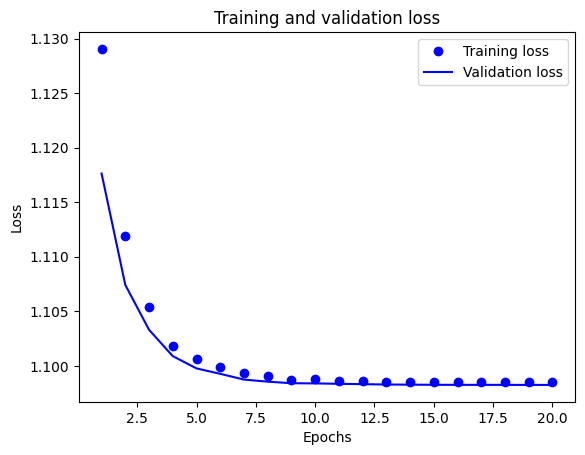

In [29]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
# Get predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred[:50]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

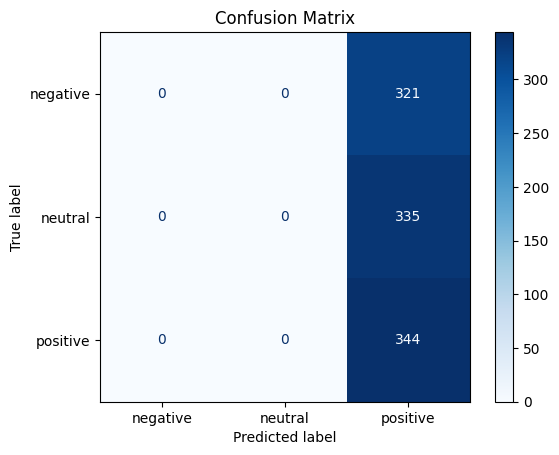


Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00       321
     neutral       0.00      0.00      0.00       335
    positive       0.34      1.00      0.51       344

    accuracy                           0.34      1000
   macro avg       0.11      0.33      0.17      1000
weighted avg       0.12      0.34      0.18      1000



/home/tk-lpt-648/miniconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tk-lpt-648/miniconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tk-lpt-648/miniconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [ ]:
# Extract true labels from val_ds
true_labels = np.concatenate([label_batch.numpy() for _, label_batch in val_ds], axis=0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(true_labels, y_pred, target_names=label_map.keys()))

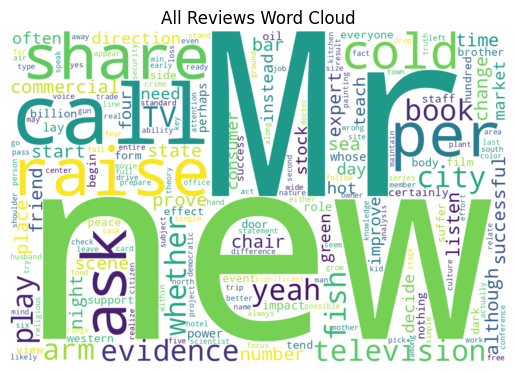

In [34]:

text_all = ' '.join(reviews)
wc = WordCloud(width=1200, height=800, background_color='white').generate(text_all)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("All Reviews Word Cloud")
plt.show()


In [35]:
# Inference from model
def predict_sentiment(texts):
    preds = model.predict(vectorize_layer(tf.constant(texts)))
    labels = [label_map_rev[i] for i in np.argmax(preds, axis=1)]
    return list(zip(texts, labels))

examples = [
    "The movie was fantastic and emotional!",
    "The film was boring and too long.",
    "It was okay, not too bad."
]

results = predict_sentiment(examples)
print("\nPredictions:")
for text, label in results:
    print(f"{label} : {text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step

Predictions:
positive : The movie was fantastic and emotional!
positive : The film was boring and too long.
positive : It was okay, not too bad.
